# ML Linear Regression using MPG Dataset

# Reading file from Google Drive into Collab Notebook

In [0]:
!pip install -U -q PyDrive
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
 
#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Read the Folder ID from Google Drive (Shareable link)

In [18]:
file_list = drive.ListFile({'q': "'1mGRnAqf4xwd-HeU0cGvM0Wf6IDQCbJUG' in parents and trashed=false"}).GetList()

for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: creditcard.csv, id: 1n6rLRTcNMjxl43OAcTIYs22QMChPlylj
title: auto-mpg, id: 1jI7n9a54-ITEkr_rQpjaGmGT_Apy_u3_HFiqMoVEk7Y
title: yelp_review.csv.zip (Unzipped Files), id: 1bzpKUglpMiZb2icdhHEMGi5WiO_K8BVT
title: glove.pdf, id: 1gEcHw1ZZaASaej1qS3GSKbT-_2oybbBO
title: yelp_review.csv.zip, id: 17oyUDgKQtDbLHA-ZWmKLEAfr7OnL74b-
title: loan.csv, id: 1_MhHDvSkNuaQHUIe4GVtjRfz0ASFdLIg
title: auto-mpg.csv, id: 1Koi8ZVwM1NNPYc-Ccal71coguddPTjWX
title: mnist.pkl.gz, id: 1uMQ3GGTg41XspI7vsYNuVpFBo9nBEcIP
title: intro_to_ann.csv, id: 1sxRJHVJCeU8ShpRmovNPlQwVb9O84tkA
title: fashion-mnist_train.csv, id: 1X8yoUFkxu_7PANuGAZfwG3eMzW7zItXF
title: fashion-mnist_test.csv, id: 1bSxl6muQGwn_SLnosHeM7XKntr4h9irH
title: RealMarketPriceDataPT.csv, id: 1i2R0fq_8ZJRN7-uCnDlceo4qXM8komQ4
title: LoanStats.csv, id: 1ZGtXYVO3wfYCie6va0wg0IEOUcSqui5x
title: adult_train.csv, id: 1kFDJDaMCelJQDdpbq0dPJRwAA1C0aO7W
title: adult_test.csv, id: 1V9d8q6u2af_2qq4G2HyApcJYh2QZ-sHh
title: regu-46-spring-2018.csv, id: 12

In [0]:
file_id='1Koi8ZVwM1NNPYc-Ccal71coguddPTjWX'
file_name='auto-mpg.csv'

train_downloaded = drive.CreateFile({'id':file_id })
train_downloaded.GetContentFile(file_name) 

In [20]:
!ls

auto-mpg.csv  datalab


# Read MPG Dataset (auto-mpg.csv) from Google Drive into Pandas

In [21]:
import pandas as pd
data = pd.read_csv(file_name,na_values=['NA','?'])
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


# Import required Libraries

In [0]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics

# Helper Functions

In [0]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        

In [24]:
# check missing values
data.isnull().values.any()

True

In [25]:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
year            0
origin          0
name            0
dtype: int64

In [26]:
df1 = data[data.isnull().any(axis=1)]
print (df1)

      mpg  cylinders  displacement  horsepower  weight  acceleration  year  \
32   25.0          4          98.0         NaN    2046          19.0    71   
126  21.0          6         200.0         NaN    2875          17.0    74   
330  40.9          4          85.0         NaN    1835          17.3    80   
336  23.6          4         140.0         NaN    2905          14.3    80   
354  34.5          4         100.0         NaN    2320          15.8    81   
374  23.0          4         151.0         NaN    3035          20.5    82   

     origin                  name  
32        1            ford pinto  
126       1         ford maverick  
330       2  renault lecar deluxe  
336       1    ford mustang cobra  
354       2           renault 18i  
374       1        amc concord dl  


In [0]:
missing_median(data, 'horsepower')
data.drop('name',1,inplace=True)

In [28]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


In [29]:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
year            0
origin          0
dtype: int64

In [30]:
data.shape

(398, 8)

In [31]:
# Drop outliers in MPG
print("Length before MPG outliers dropped: {}".format(len(data)))
remove_outliers(data,'mpg',2)
print("Length after MPG outliers dropped: {}".format(len(data)))


Length before MPG outliers dropped: 398
Length after MPG outliers dropped: 388


In [32]:
data.shape

(388, 8)

In [33]:
preprocess = True

if preprocess:
  encode_text_dummy(data, 'origin')
  
  encode_numeric_zscore(data,'mpg')
  encode_numeric_zscore(data,'cylinders')
  encode_numeric_zscore(data,'horsepower')
  encode_numeric_zscore(data,'weight')
  encode_numeric_zscore(data,'acceleration')
  encode_numeric_zscore(data,'displacement')

data.head()



,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin-1,origin-2,origin-3
0,-0.691361,1.469532,1.063827,0.647254,0.604084,-1.299996,70,1,0,0
1,-1.104856,1.469532,1.476309,1.566728,0.827841,-1.487212,70,1,0,0
2,-0.691361,1.469532,1.169346,1.172668,0.523579,-1.674429,70,1,0,0
3,-0.967024,1.469532,1.035050,1.172668,0.520028,-1.299996,70,1,0,0
4,-0.829193,1.469532,1.015864,0.909961,0.538970,-1.861645,70,1,0,0


# Explore Dataset after Normalization

In [0]:
# conventional way to import seaborn
import seaborn as sns;sns.set()

# allow plots to appear within the notebook
%matplotlib inline

import matplotlib.pyplot as plt

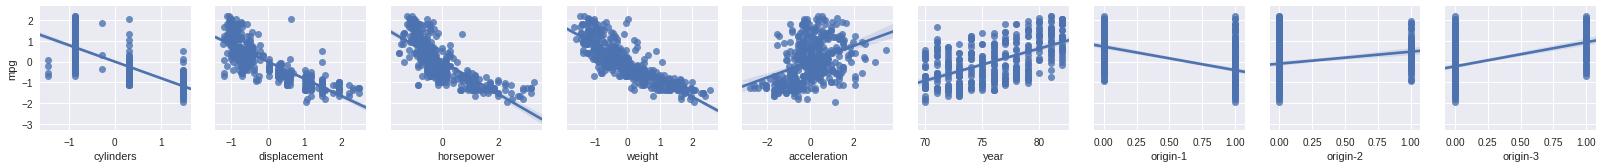

In [64]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=['cylinders','displacement','horsepower','weight','acceleration','year','origin-1','origin-2','origin-3'], y_vars='mpg', kind='reg')

##sns.pairplot(data, x_vars=['cylinders','displacement','horsepower','weight','acceleration','year','origin-1','origin-2','origin-3'], y_vars='mpg', size=7, aspect=0.7, kind='reg')


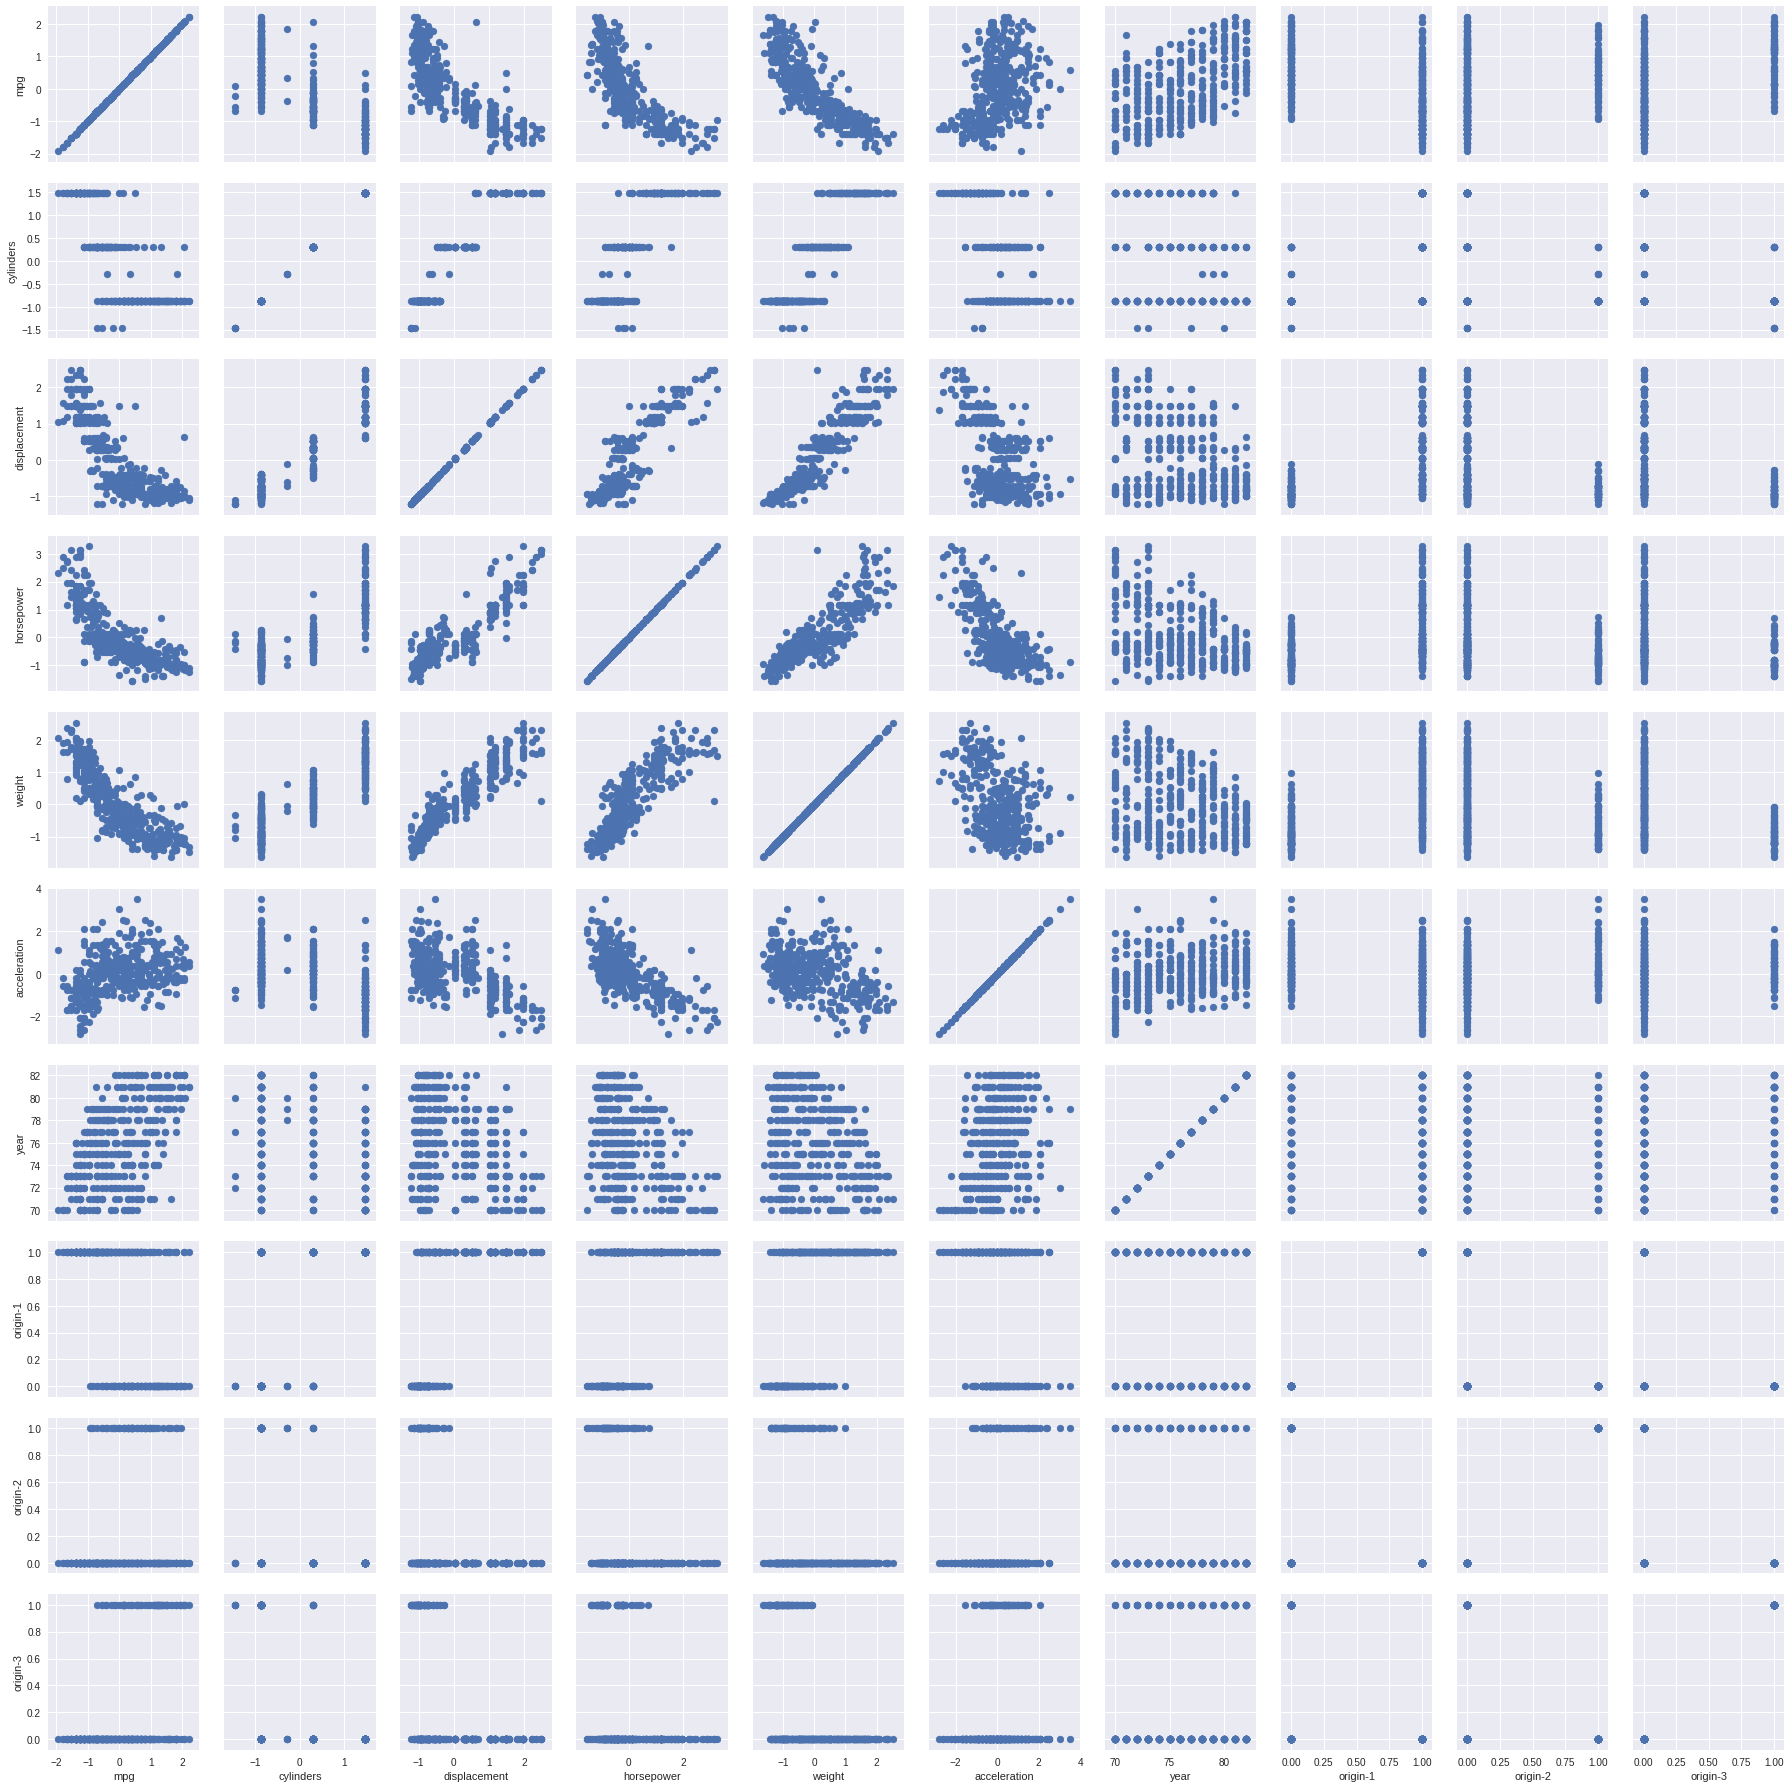

In [36]:
# visualize the relationship between the features using scatterplots
g = sns.PairGrid(data)
g = g.map(plt.scatter)

# Split Dataset into Training and Test Data

In [37]:
data.dtypes

mpg             float64
cylinders       float64
displacement    float64
horsepower      float64
weight          float64
acceleration    float64
year              int64
origin-1          uint8
origin-2          uint8
origin-3          uint8
dtype: object

In [38]:
# Encode to a 2D matrix for training
X,y = to_xy(data,'mpg')

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((310, 9), (310, 1), (78, 9), (78, 1))

# Import Algorithm

In [0]:
# import model
from sklearn.linear_model import LinearRegression

# Instantiate Algorithm Class

In [0]:
# instantiate
linreg = LinearRegression()

# Fit Model

In [41]:
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

# Interpreting Model Coefficients

In [42]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[-7.1448298]
[[-0.13248627  0.24744089 -0.18555482 -0.63592035 -0.04297984  0.09515704
  -0.19680901  0.03235214  0.16445689]]


# Predict 

In [0]:
# Predict and measure RMSE
y_pred = linreg.predict(X_test)

In [44]:
y_pred[0:5]

array([[ 0.8679447 ],
       [-0.05594921],
       [ 0.79596424],
       [-2.1130238 ],
       [ 1.0400314 ]], dtype=float32)

# Evaluate

In [45]:
score = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.3992045223712921


# Plot

[-7.1448298]
[[-0.13248627  0.24744089 -0.18555482 -0.63592035 -0.04297984  0.09515704
  -0.19680901  0.03235214  0.16445689]]


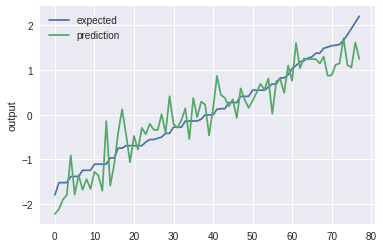

In [46]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)
# Plot the chart
chart_regression(y_pred.flatten(),y_test)

In [47]:
y_pred[0:5]

array([[ 0.8679447 ],
       [-0.05594921],
       [ 0.79596424],
       [-2.1130238 ],
       [ 1.0400314 ]], dtype=float32)

In [48]:
y_pred[0:5].flatten()

array([ 0.8679447 , -0.05594921,  0.79596424, -2.1130238 ,  1.0400314 ],
      dtype=float32)

In [49]:
y_test[0:5]

array([[ 0.12184606],
       [-0.14003415],
       [ 0.8247877 ],
       [-1.5183511 ],
       [ 1.18315   ]], dtype=float32)

In [50]:
y_test[0:5].flatten()

array([ 0.12184606, -0.14003415,  0.8247877 , -1.5183511 ,  1.18315   ],
      dtype=float32)

# Feature Selection

In [51]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin-1,origin-2,origin-3
0,-0.691361,1.469532,1.063827,0.647254,0.604084,-1.299996,70,1,0,0
1,-1.104856,1.469532,1.476309,1.566728,0.827841,-1.487212,70,1,0,0
2,-0.691361,1.469532,1.169346,1.172668,0.523579,-1.674429,70,1,0,0
3,-0.967024,1.469532,1.035050,1.172668,0.520028,-1.299996,70,1,0,0
4,-0.829193,1.469532,1.015864,0.909961,0.538970,-1.861645,70,1,0,0


In [52]:
print(linreg.intercept_)
print(linreg.coef_)

[-7.1448298]
[[-0.13248627  0.24744089 -0.18555482 -0.63592035 -0.04297984  0.09515704
  -0.19680901  0.03235214  0.16445689]]


In [0]:
X,y=to_xy(data,'mpg')

In [54]:
X[0]

array([ 1.4695323,  1.0638274,  0.6472543,  0.6040843, -1.299996 ,
       70.       ,  1.       ,  0.       ,  0.       ], dtype=float32)

In [55]:
y[0]

array([-0.69136095], dtype=float32)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

X_train.shape,y_train.shape,X_test.shape,y_test.shape

((310, 9), (310, 1), (78, 9), (78, 1))

In [57]:
# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [58]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)

[-7.1448298]
[[-0.13248627  0.24744089 -0.18555482 -0.63592035 -0.04297984  0.09515704
  -0.19680901  0.03235214  0.16445689]]


In [0]:
# Predict and measure RMSE
y_pred = linreg.predict(X_test)

In [60]:
score = np.sqrt(metrics.mean_squared_error(y_pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 0.3992045223712921


[-7.1448298]
[[-0.13248627  0.24744089 -0.18555482 -0.63592035 -0.04297984  0.09515704
  -0.19680901  0.03235214  0.16445689]]


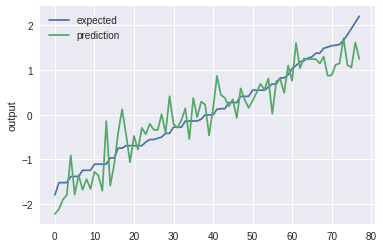

In [61]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)
# Plot the chart
chart_regression(y_pred.flatten(),y_test)

In [62]:
metrics.r2_score(y_test,y_pred)

0.8460460581032149